In [172]:
## knjižnice:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import arch

In [173]:
## podatki, ki so nam jih poslali:
podatki = pd.read_csv(os.path.join('C:/Users/Uporabnik/OneDrive/Namizje/SOLA/MAGISTERIJ/MATEMATIKA Z RACUNALNIKOM/GospodinjskiOdjemalci.csv'), sep=";")
# Malo boljši format:
podatki['DateTimeStartUTC'] = pd.to_datetime(podatki['DateTimeStartUTC'], format='%d.%m.%Y %H:%M')
podatki['DateTimeStartCET'] = pd.to_datetime(podatki['DateTimeStartCET'], format='%d.%m.%Y %H:%M')

podatki = podatki[['DateTimeStartUTC', 'Odjem ACT', 'Temperatura ACT', 'Temperatura FC', 'Sevanje ACT', 'Sevanje FC']]

podatki.set_index('DateTimeStartUTC', inplace=True)
podatki['Year'] = podatki.index.year
podatki['Month'] = podatki.index.month
podatki['Day'] = podatki.index.date
podatki['Time'] = podatki.index.time

podatki = podatki.asfreq('15T')

podatki['Odjem ACT'] = podatki['Odjem ACT'] * 1000000000 # da dobim MWh (bo lepše pri logaritmu tega stolpce v nadaljevanju)

podatki


,Odjem ACT,Temperatura ACT,Temperatura FC,Sevanje ACT,Sevanje FC,Year,Month,Day,Time
DateTimeStartUTC,,,,,,,,,
2021-10-31 23:00:00,9508.67,3.60,5.300,0.0,0.0,2021,10,2021-10-31,23:00:00
2021-10-31 23:15:00,9168.37,3.60,5.300,0.0,0.0,2021,10,2021-10-31,23:15:00
2021-10-31 23:30:00,8860.11,3.60,5.300,0.0,0.0,2021,10,2021-10-31,23:30:00
2021-10-31 23:45:00,8510.97,3.60,5.300,0.0,0.0,2021,10,2021-10-31,23:45:00
2021-11-01 00:00:00,8332.21,3.45,5.300,0.0,0.0,2021,11,2021-11-01,00:00:00
...,...,...,...,...,...,...,...,...,...
2024-02-29 21:45:00,12005.50,6.80,7.475,0.0,0.0,2024,2,2024-02-29,21:45:00
2024-02-29 22:00:00,11336.40,6.65,7.300,0.0,0.0,2024,2,2024-02-29,22:00:00
2024-02-29 22:15:00,10796.70,6.50,7.300,0.0,0.0,2024,2,2024-02-29,22:15:00


In [174]:
sns.set(rc={'figure.figsize':(20, 6)}) 
plt.style.use('seaborn-white')

Text(0, 0.5, 'Odjem [MWh]')

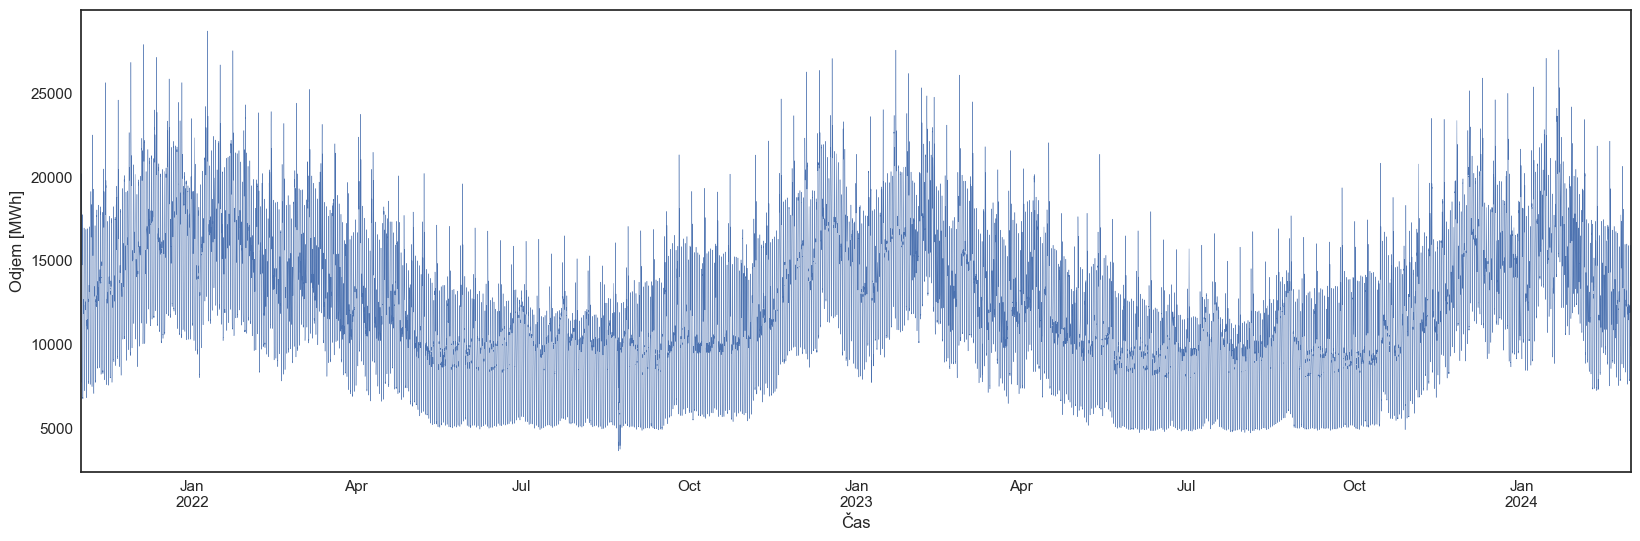

In [175]:
plt.style.use('seaborn-white')
podatki['Odjem ACT'].plot(linewidth=0.3)
# plt.title('Odjem električne energije gospodinjskih odjemalcev, 2021-2024', fontsize=20, weight='bold')
plt.xlabel('Čas')
plt.ylabel('Odjem [MWh]')

In [176]:
## Številki opis podatkov:
pd.DataFrame([('Odjem', podatki['Odjem ACT'].min(), podatki['Odjem ACT'].max(), podatki['Odjem ACT'].mean(), podatki['Odjem ACT'].median(), podatki['Odjem ACT'].std())],
                    columns=(' ', 'Min', 'Max', 'Povprečje', 'Mediana', 'sd' ))

,,Min,Max,Povprečje,Mediana,sd
0,Odjem,3629.32,28736.8,12240.501427,11708.45,4167.961058


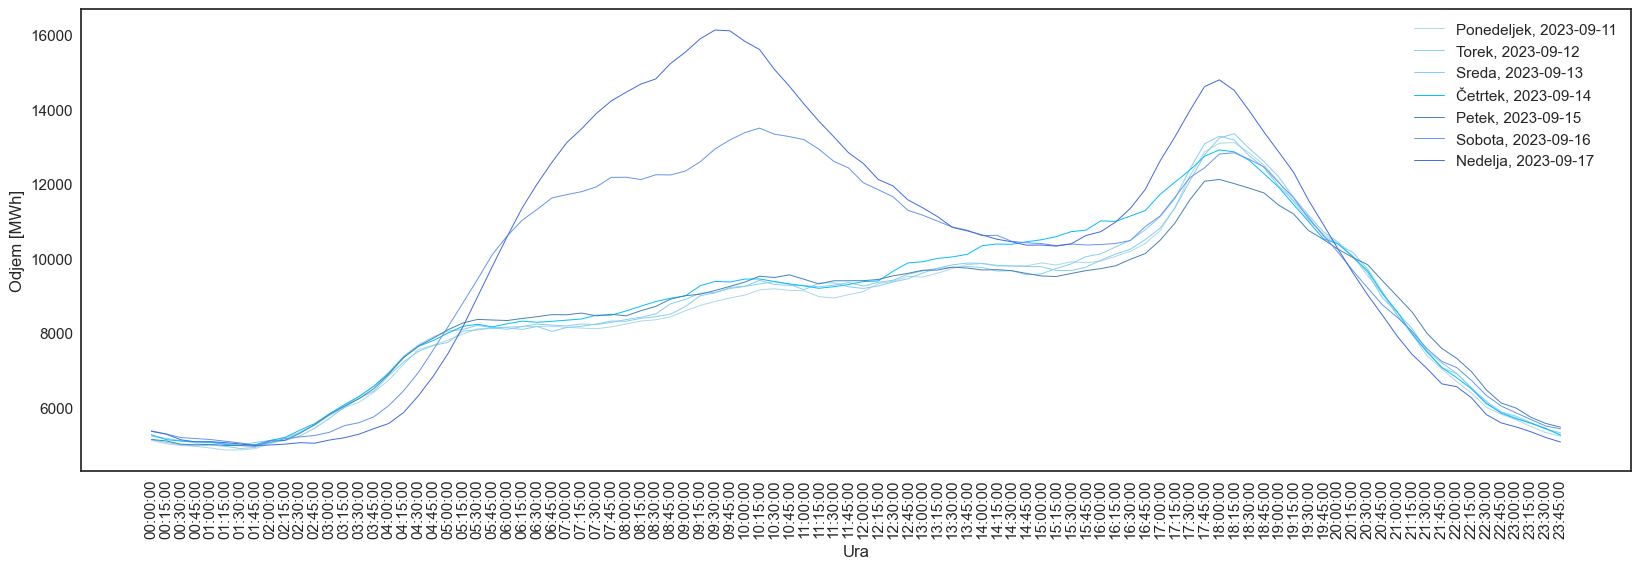

In [177]:
plt.xticks(rotation = 90)
plt.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-11', 'Odjem ACT'], label='Ponedeljek, 2023-09-11', color='lightblue', linewidth=0.7)
plt.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-12', 'Odjem ACT'], label='Torek, 2023-09-12', color='skyblue', linewidth=0.7)
plt.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-13', 'Odjem ACT'], label='Sreda, 2023-09-13', color='lightskyblue', linewidth=0.7)
plt.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-14', 'Odjem ACT'], label='Četrtek, 2023-09-14', color='deepskyblue', linewidth=0.7)
plt.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-15', 'Odjem ACT'], label='Petek, 2023-09-15', color='steelblue', linewidth=0.7)
plt.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-16', 'Odjem ACT'], label='Sobota, 2023-09-16', color='cornflowerblue', linewidth=0.7)
plt.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-17', 'Odjem ACT'], label='Nedelja, 2023-09-17', color='royalblue', linewidth=0.7)
plt.xlabel('Ura')
plt.ylabel('Odjem [MWh]')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


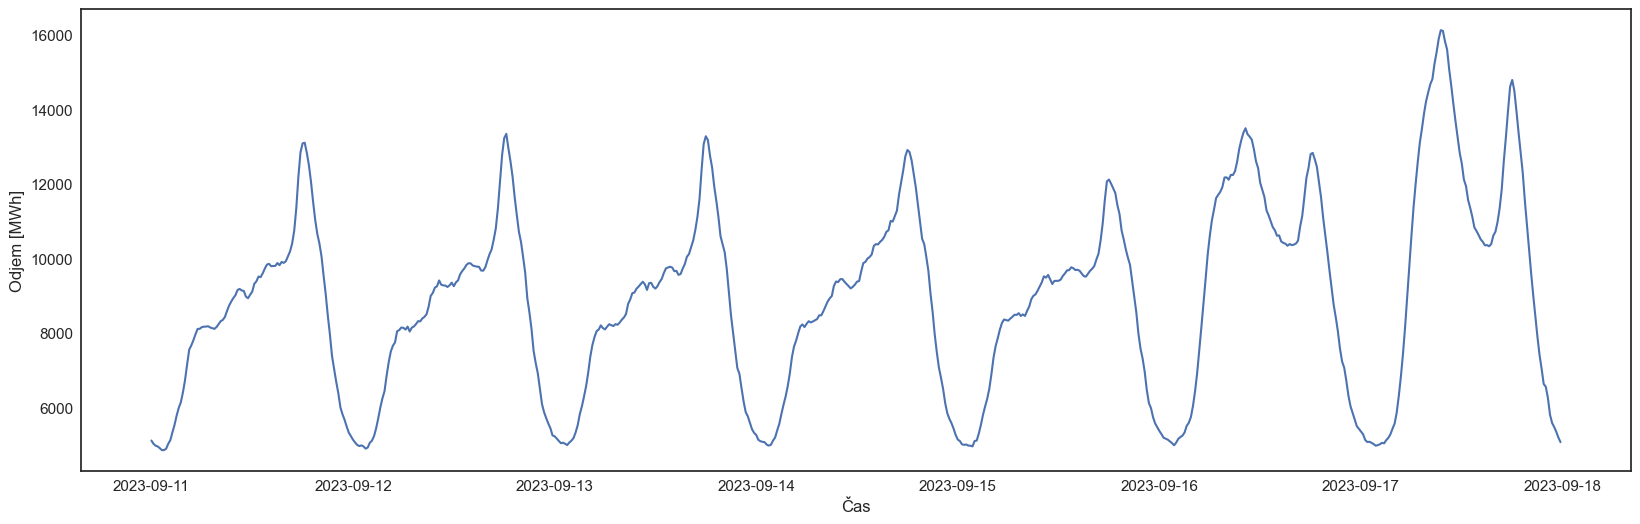

In [178]:
plt.plot(podatki.loc['2023-09-11':'2023-09-17', 'Odjem ACT'])
plt.xlabel('Čas')
plt.ylabel('Odjem [MWh]')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


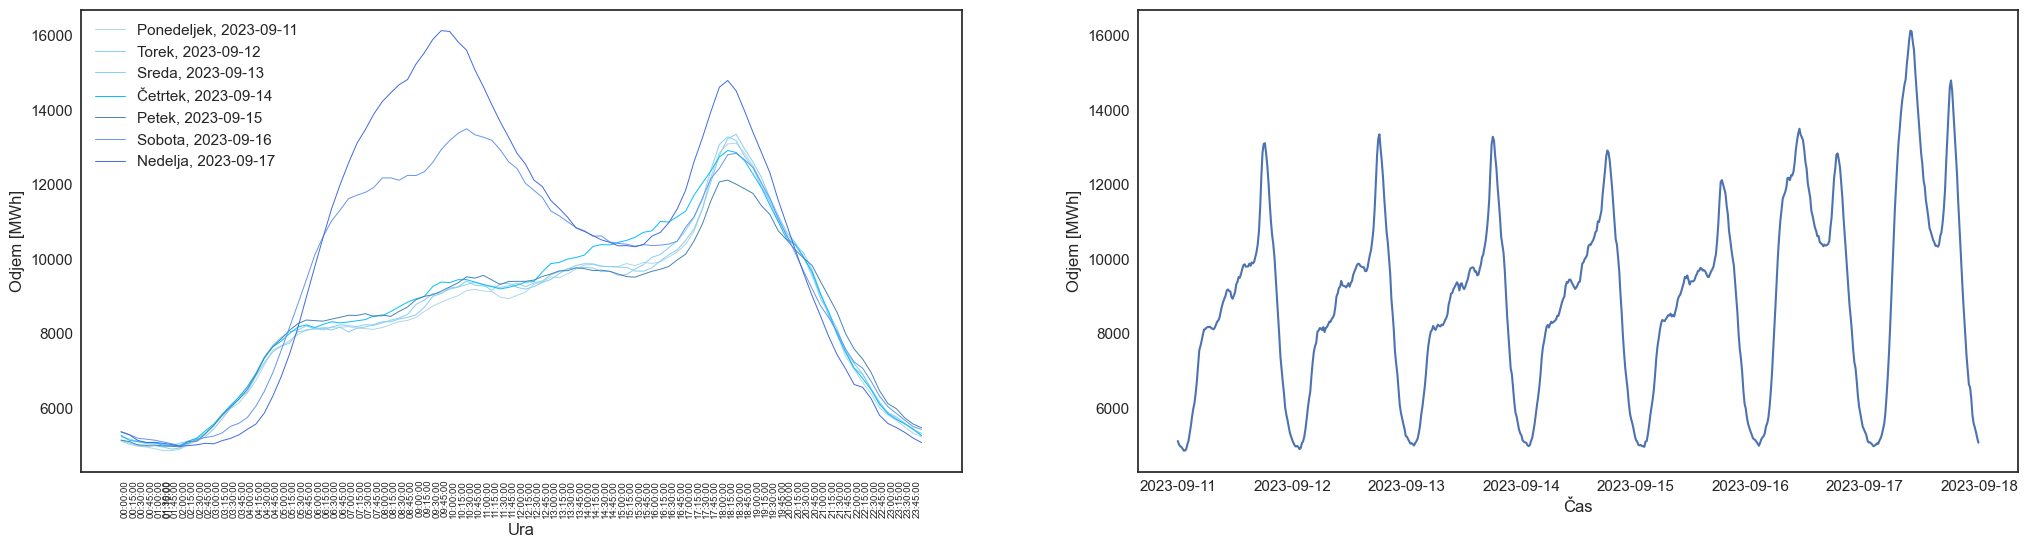

In [194]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(25, 6))

plt.setp(ax1.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
ax1.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-11', 'Odjem ACT'], label='Ponedeljek, 2023-09-11', color='lightblue', linewidth=0.7)
ax1.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-12', 'Odjem ACT'], label='Torek, 2023-09-12', color='skyblue', linewidth=0.7)
ax1.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-13', 'Odjem ACT'], label='Sreda, 2023-09-13', color='lightskyblue', linewidth=0.7)
ax1.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-14', 'Odjem ACT'], label='Četrtek, 2023-09-14', color='deepskyblue', linewidth=0.7)
ax1.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-15', 'Odjem ACT'], label='Petek, 2023-09-15', color='steelblue', linewidth=0.7)
ax1.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-16', 'Odjem ACT'], label='Sobota, 2023-09-16', color='cornflowerblue', linewidth=0.7)
ax1.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-17', 'Odjem ACT'], label='Nedelja, 2023-09-17', color='royalblue', linewidth=0.7)
ax1.tick_params(axis="x", labelsize=7)
ax1.set(xlabel = 'Ura', ylabel = 'Odjem [MWh]')
ax1.legend()

ax2.plot(podatki.loc['2023-09-11':'2023-09-17', 'Odjem ACT'])
ax2.set(xlabel = 'Čas', ylabel = 'Odjem [MWh]')
ax2.legend()

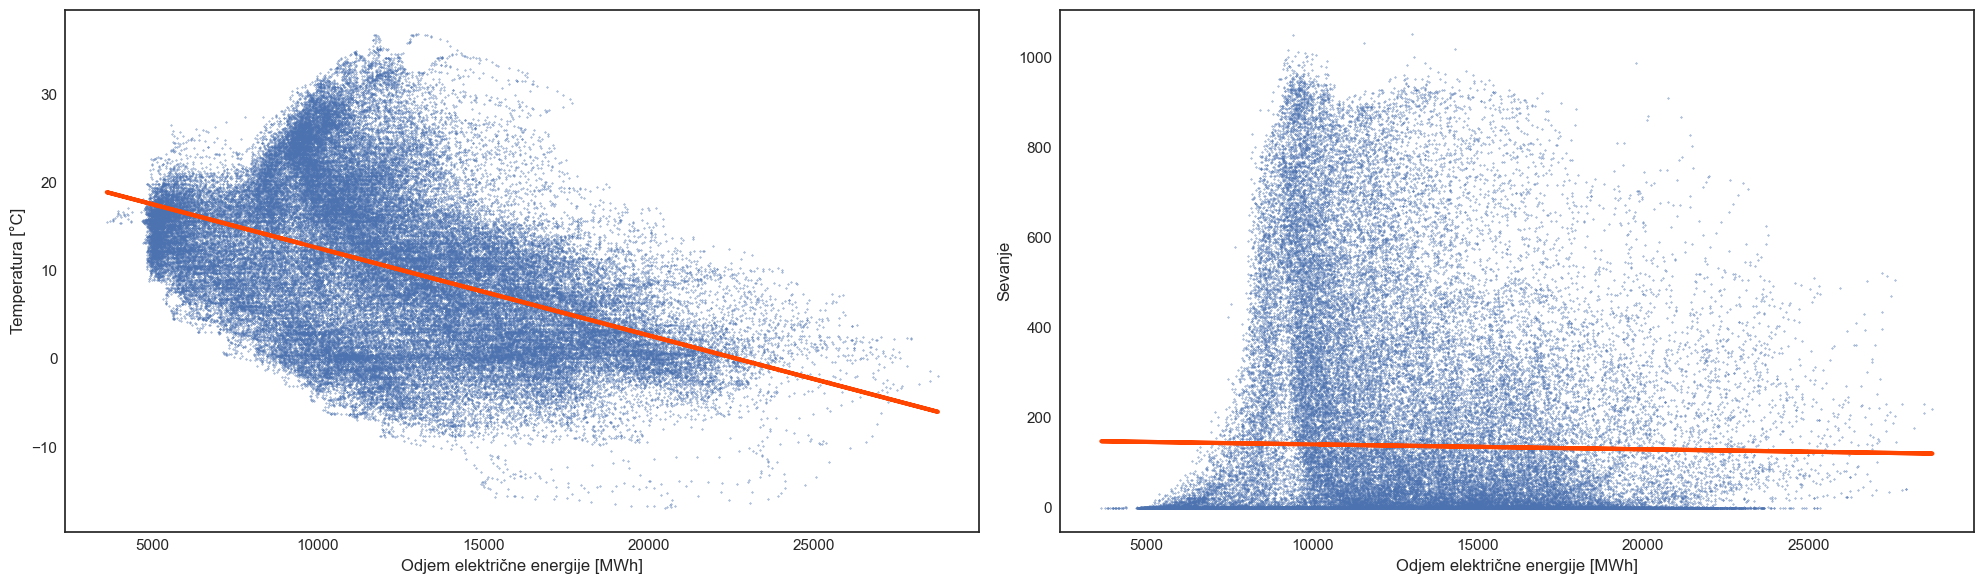

In [243]:
# Povezava med temperaturo in odjemom:

# temperatura
X = np.array(podatki["Odjem ACT"]).reshape(-1, 1)
y = np.array(podatki["Temperatura ACT"])
reg = LinearRegression().fit(X, y)
podatki['predicted'] = reg.predict(X)

# sevanje
X_S = np.array(podatki["Odjem ACT"]).reshape(-1, 1)
y_S = np.array(podatki["Sevanje ACT"])
reg = LinearRegression().fit(X_S, y_S)
podatki['predicted_S'] = reg.predict(X_S)


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 6))

ax1 = plt.subplot(1, 2, 1)
podatki.plot.scatter(x = "Odjem ACT", y = "Temperatura ACT", s = 0.1, ax = ax1, legend=False)
podatki.plot.line(x = "Odjem ACT", y = 'predicted', ax = ax1, color="orangered", legend=False, linewidth=3)
plt.xlabel('Odjem električne energije [MWh]')
plt.ylabel('Temperatura [°C]')

ax1 = plt.subplot(1, 2, 2)
podatki.plot.scatter(x = "Odjem ACT", y = "Sevanje ACT", s = 0.1, ax = ax2, legend=False)
podatki.plot.line(x = "Odjem ACT", y = 'predicted_S', ax = ax2, color="orangered", legend=False, linewidth=3)
plt.xlabel('Odjem električne energije [MWh]')
plt.ylabel('Sevanje')

plt.tight_layout()


In [197]:
podatki['log return'] = np.log(podatki['Odjem ACT']/podatki['Odjem ACT'].shift(-1))
podatki = podatki.dropna()
podatki

,Odjem ACT,Temperatura ACT,Temperatura FC,Sevanje ACT,Sevanje FC,Year,Month,Day,Time,log return
DateTimeStartUTC,,,,,,,,,,
2021-10-31 23:00:00,9508.67,3.60,5.300,0.0,0.0,2021,10,2021-10-31,23:00:00,0.036444
2021-10-31 23:15:00,9168.37,3.60,5.300,0.0,0.0,2021,10,2021-10-31,23:15:00,0.034200
2021-10-31 23:30:00,8860.11,3.60,5.300,0.0,0.0,2021,10,2021-10-31,23:30:00,0.040203
2021-10-31 23:45:00,8510.97,3.60,5.300,0.0,0.0,2021,10,2021-10-31,23:45:00,0.021227
2021-11-01 00:00:00,8332.21,3.45,5.300,0.0,0.0,2021,11,2021-11-01,00:00:00,0.004812
...,...,...,...,...,...,...,...,...,...,...
2024-02-29 21:30:00,12529.80,6.85,7.650,0.0,0.0,2024,2,2024-02-29,21:30:00,0.042745
2024-02-29 21:45:00,12005.50,6.80,7.475,0.0,0.0,2024,2,2024-02-29,21:45:00,0.057346
2024-02-29 22:00:00,11336.40,6.65,7.300,0.0,0.0,2024,2,2024-02-29,22:00:00,0.048778


Text(0, 0.5, 'Log returns')

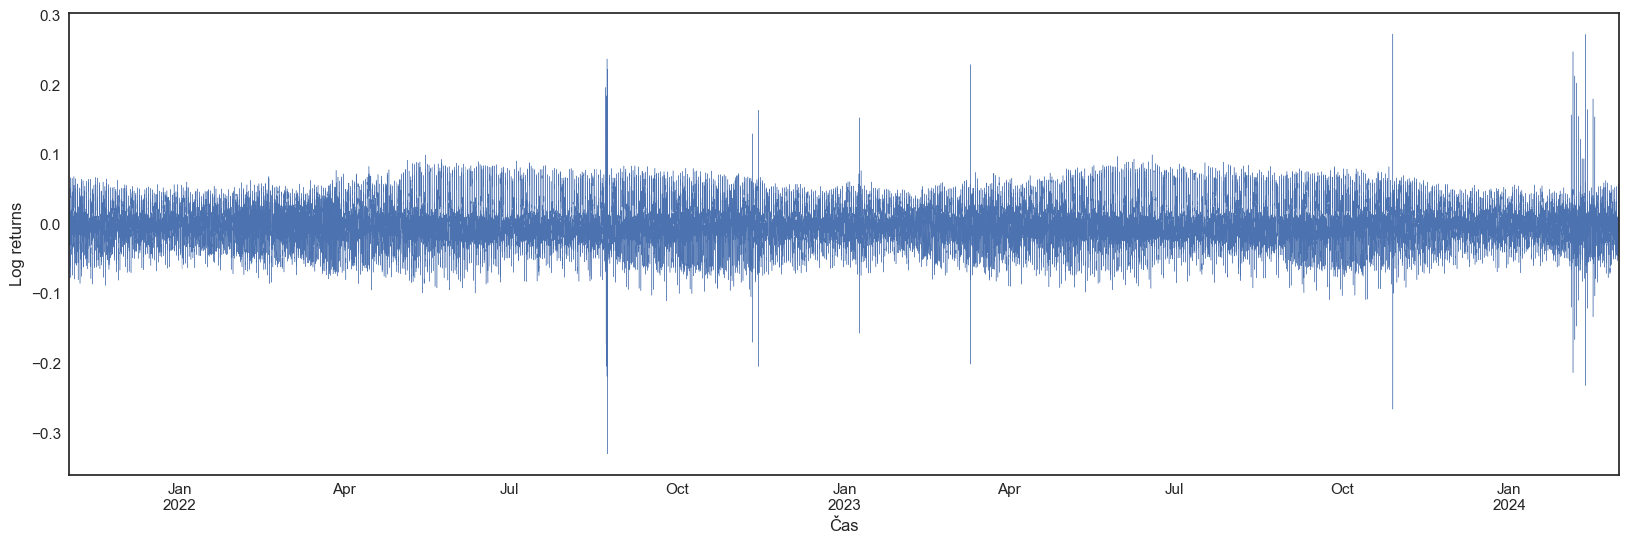

In [199]:
podatki['log return'].plot(linewidth=0.3)
plt.xlabel('Čas')
plt.ylabel('Log returns')
# to je ful bolj stacionarno

In [200]:
from arch.unitroot import *

def preveri_stacionarnost(ts):
    print(ADF(ts).summary())
    print('\n')
    print(KPSS(ts).summary())
    print('\n')
    print(PhillipsPerron(ts).summary())

In [201]:
preveri_stacionarnost(podatki['log return'])

# vsi testi povedo, da je časovna vrsta stacionarna

   Augmented Dickey-Fuller Results   
Test Statistic                -83.893
P-value                         0.000
Lags                               65
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


    KPSS Stationarity Test Results   
Test Statistic                  0.001
P-value                         1.000
Lags                              133
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


     Phillips-Perron Test (Z-tau)    
Test Statistic                -58.607
P-value                         0.000
Lags                               65
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
N

In [210]:
def plot_acf_pach (time_series, n_lags):

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 6))

    tsaplots.plot_acf(time_series, lags=n_lags, ax=ax1)
    ax1.set(xlabel = 'Odlogi', ylabel = 'ACF', title = 'Vzorčna avtokorelacijska funkcija')

    tsaplots.plot_pacf(time_series, lags=n_lags, ax=ax2)
    ax2.set(xlabel = 'Odlogi', ylabel = 'PACF', title = 'Vzorčna parcialna avtokorelacijska funkcija')

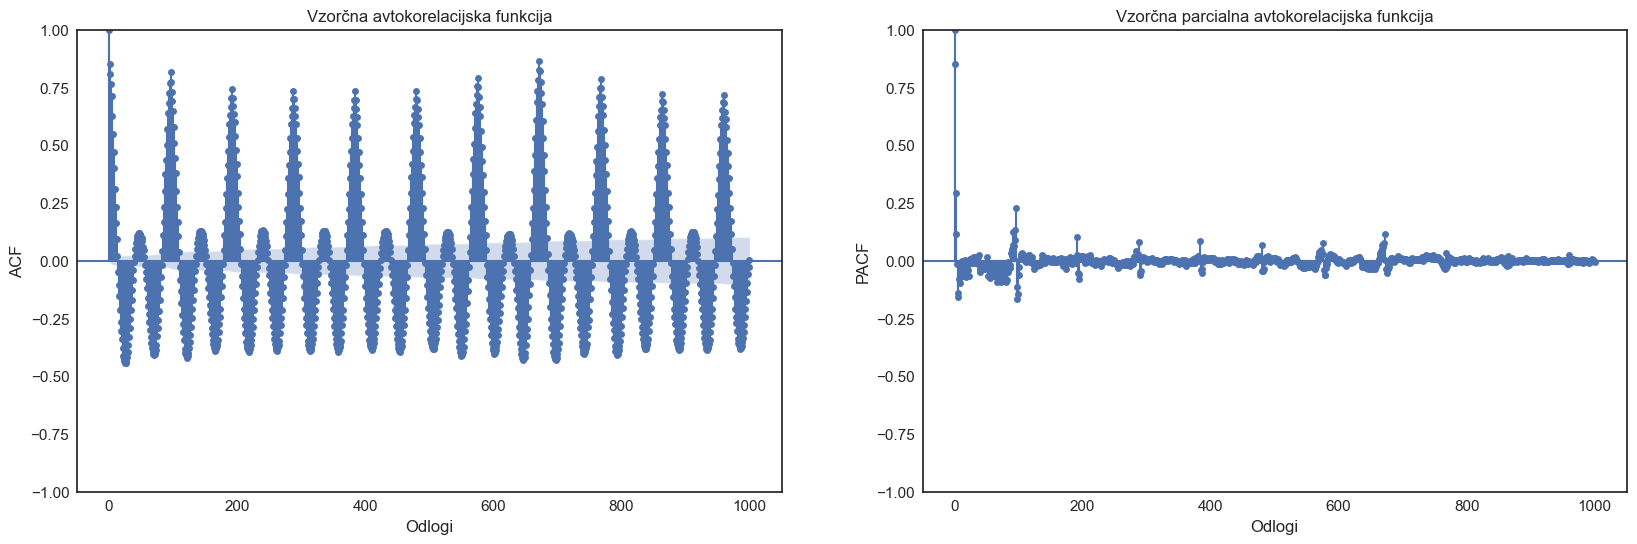

In [211]:
plot_acf_pach(podatki['log return'], 1000)

In [212]:
ts_diff = podatki['log return'].diff(periods = 96).dropna()

Text(0, 0.5, '')

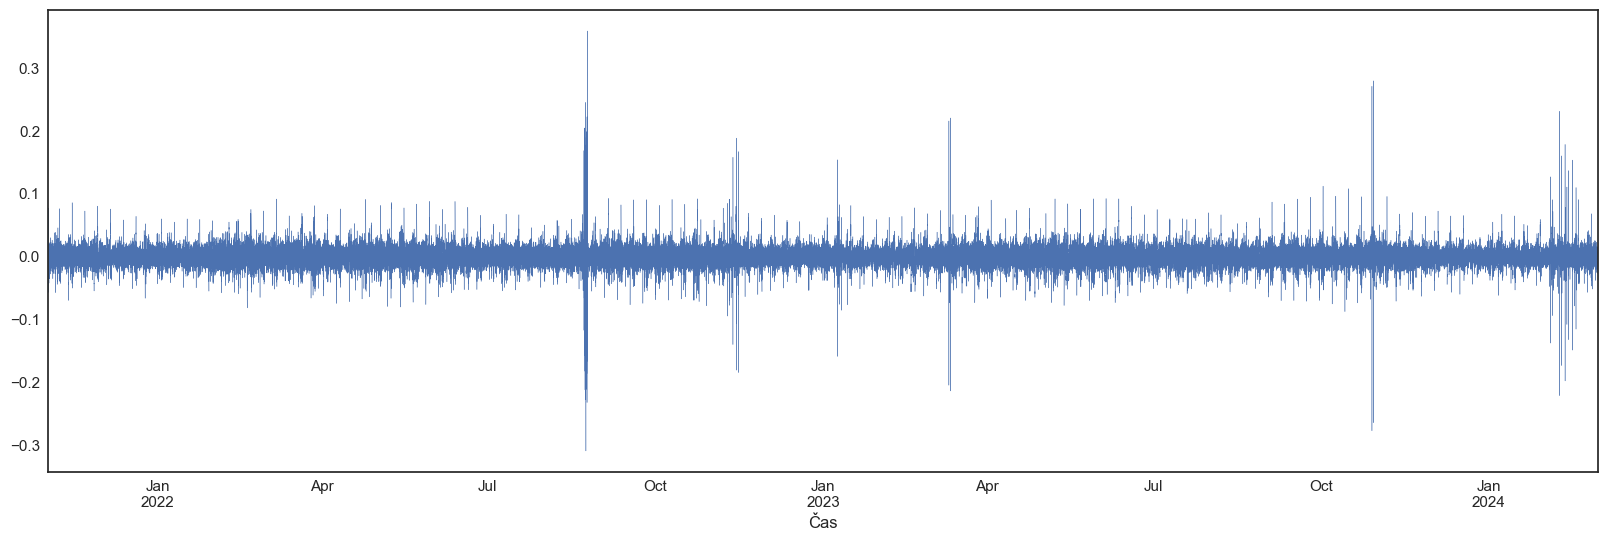

In [213]:
ts_diff.plot(linewidth=0.3) 
plt.xlabel('Čas')
plt.ylabel('')

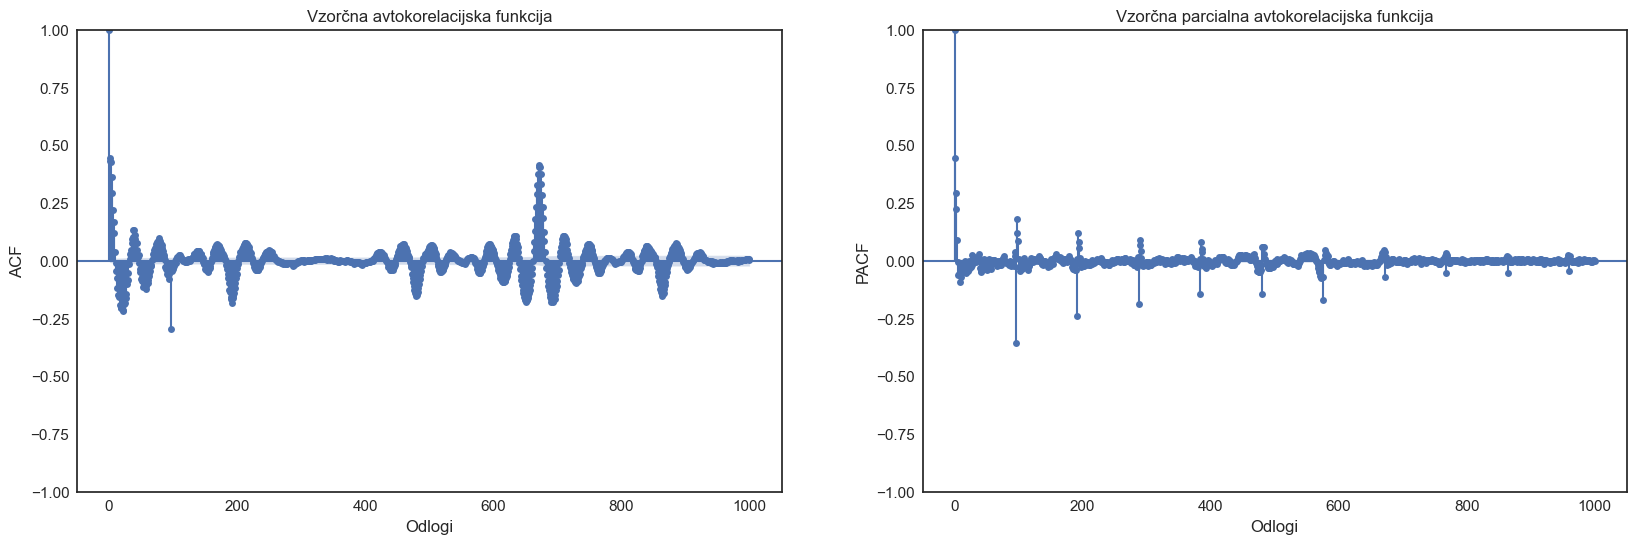

In [214]:
plot_acf_pach(ts_diff, 1000)

In [215]:
ts_diff_2 = ts_diff.diff().dropna()

Text(0, 0.5, '')

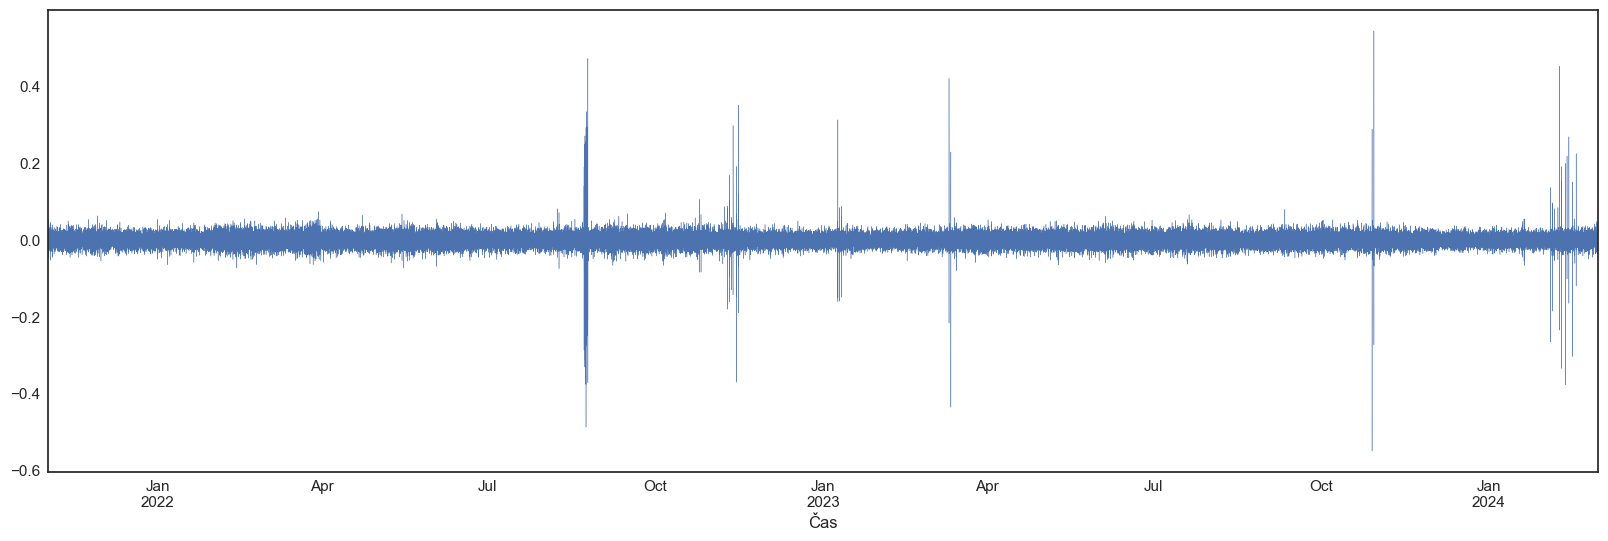

In [216]:
ts_diff_2.plot(linewidth=0.3) 
plt.xlabel('Čas')
plt.ylabel('')

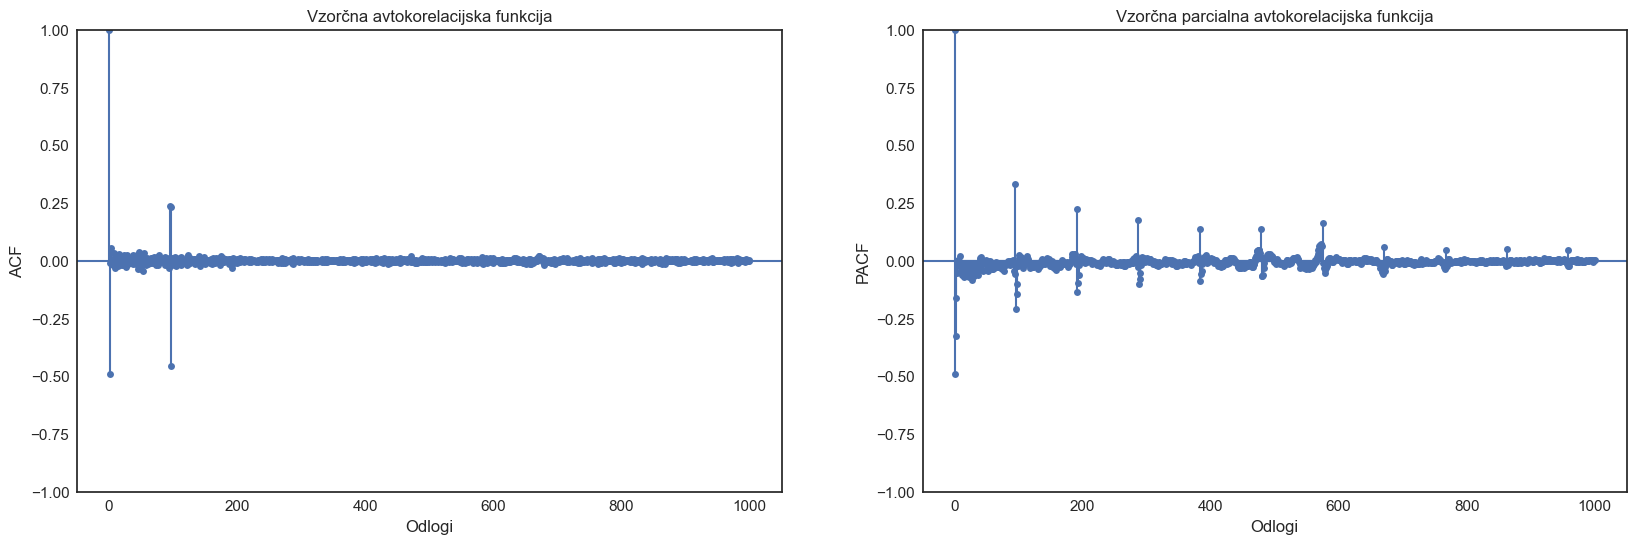

In [217]:
plot_acf_pach(ts_diff_2, 1000)

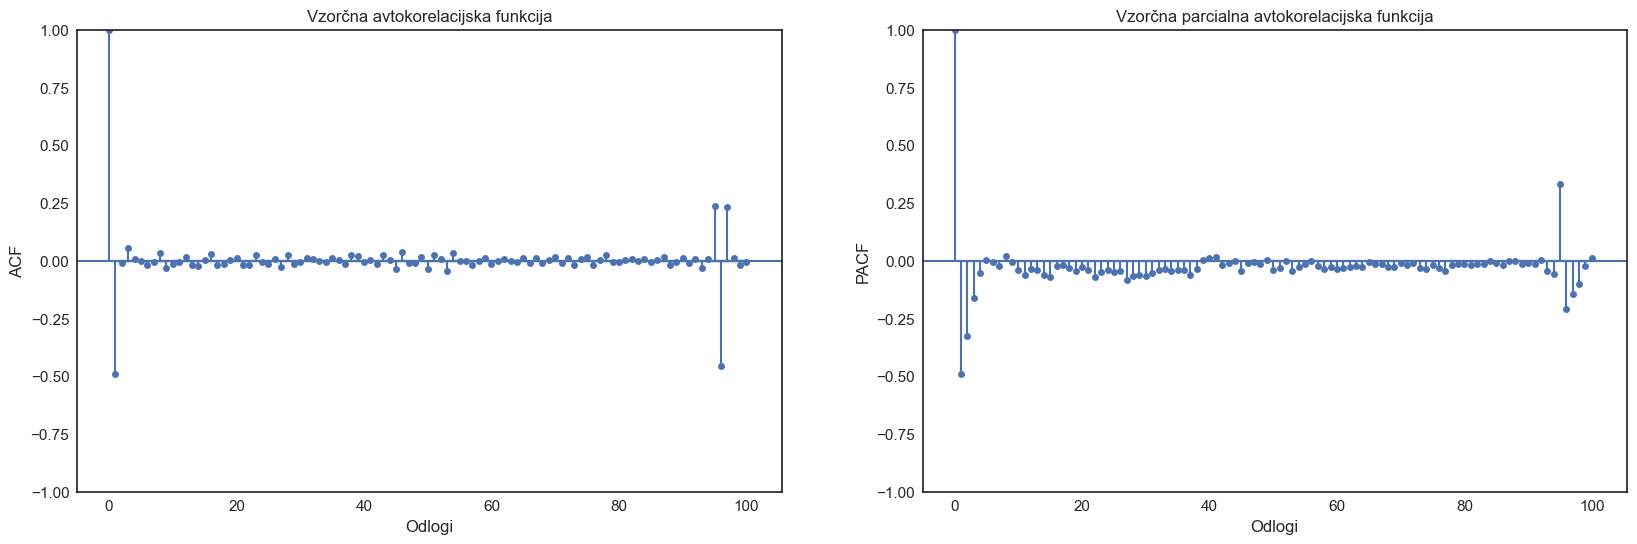

In [218]:
plot_acf_pach(ts_diff_2, 100)

# q je 1 ali pa 95
# p je 1, 2, 3 ali 95

In [28]:
preveri_stacionarnost(ts_diff_2)

# vsi testi povedo, da je stacionarna

   Augmented Dickey-Fuller Results   
Test Statistic                -64.756
P-value                         0.000
Lags                               65
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


    KPSS Stationarity Test Results   
Test Statistic                  0.002
P-value                         1.000
Lags                              243
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


     Phillips-Perron Test (Z-tau)    
Test Statistic              -1501.246
P-value                         0.000
Lags                               65
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
N

In [220]:
# TRAIN na 75 % (od 2021-11-01 23:00:00 do 2023-08-04 23:45:00)
# TEST na 25 %

start = 0
end = 61540

# train data:
df = podatki[(start+96):(end+96)]

train_data_log = df['log return']
train_data_diff_96 = ts_diff[(start):(end)] # !!
train_exog = df[['Temperatura FC', 'Sevanje FC']]

# test data:
df_test = podatki[(end+96):(end+96+96)]

day = '2023-08-05'
next_day = '2023-08-06'

test_data_log = df_test['log return']
test_data_diff_96 = ts_diff[end:(end+96)] # !!
test_exog = df_test[['Temperatura FC', 'Sevanje FC']]

In [92]:
# delala bom na ts_diff (torej na 1x sezonsko diferenciranih) --> d = 1 
# na koncu bom oddiferencirala in naredila inverz od log returns da pridem nazaj na originalno skalo

In [257]:
def RMSE_MAPE (podatki_OG, napoved):
    '''Funkcija RMSE_MAPE izračuna napaki RMSE in MAPE. Vrne seznam oblike [RMSE, MAPE]'''
    errors = podatki_OG - napoved
    mse = np.mean(errors**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs(errors / podatki_OG)) * 100
    return [rmse, mape]

def napoved_na_OG_skala (podatki, napoved, dan, naslednji_dan):
    '''Najprej dediferenciramo in nato naredimo inverz log returnov.'''
    napoved_ = napoved + podatki['log return'].shift(-96)[dan]
    
    start = dan + ' 00:00:00'
    end = naslednji_dan + ' 00:00:00'

    return(np.exp(napoved_ + np.log(podatki.loc[start:end, 'Odjem ACT'].shift(-1)[dan])))

In [221]:
def ARIMA_no_exog(p, d, q, train):
    model = sm.tsa.statespace.SARIMAX(train, order=(p, d, q))
    results = model.fit()
    return results

def ARIMA_exog(p, d, q, train, exog):
    model = sm.tsa.statespace.SARIMAX(train, order=(p, d, q), exog = exog)
    results = model.fit()
    return results

def GARCH (residuali, p, q):
    model = arch.arch_model(residuali, mean='Zero', vol='Garch', p=p, q=q)
    results = model.fit()
    return results

def forecast_no_exog (results, steps):
    return results.forecast(steps)

def forecast_exog (results, steps, exog):
    return results.forecast(steps=steps, exog=exog)

In [10]:
results_1 = ARIMA_exog(1, 1, 0, train_data_diff_96, train_exog)
# 13.2s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
forecast_1 = forecast_exog(results_1, 96, test_exog)
# na OG skalo:
forecast_OG_1 = napoved_na_OG_skala(podatki, forecast_1, day, next_day)

errors_1 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_1)
errors_1

[157.0568199526522, 1.1051986523984216]

In [11]:
results_2 = ARIMA_exog(0, 1, 1, train_data_diff_96, train_exog)
# 19.4s

In [35]:
forecast_2 = forecast_exog(results_2, 96, test_exog)
# na OG skalo:
forecast_OG_2 = napoved_na_OG_skala(podatki, forecast_2, day, next_day)

errors_2 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_2)
errors_2

[156.45647377845617, 1.1021269871265158]

In [12]:
results_3 = ARIMA_exog(1, 1, 1, train_data_diff_96, train_exog)
# 42.0s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
forecast_3 = forecast_exog(results_3, 96, test_exog)
# na OG skalo:
forecast_OG_3 = napoved_na_OG_skala(podatki, forecast_3, day, next_day)

errors_3 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_3)
errors_3

[156.47263873589245, 1.1022190066927853]

In [13]:
results_4 = ARIMA_exog(2, 1, 2, train_data_diff_96, train_exog)
# 25.6s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
forecast_4 = forecast_exog(results_4, 96, test_exog)
# na OG skalo:
forecast_OG_4 = napoved_na_OG_skala(podatki, forecast_4, day, next_day)

errors_4 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_4)
errors_4

[156.98487656580875, 1.1048979316203285]

In [14]:
results_5 = ARIMA_exog(3, 1, 2, train_data_diff_96, train_exog)
# 26.4s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
forecast_5 = forecast_exog(results_5, 96, test_exog)
# na OG skalo:
forecast_OG_5 = napoved_na_OG_skala(podatki, forecast_5, day, next_day)

errors_5 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_5)
errors_5

[156.923462520095, 1.1046522982332048]

In [15]:
results_6 = ARIMA_exog(4, 1, 3, train_data_diff_96, train_exog)
# 3m

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [39]:
forecast_6 = forecast_exog(results_6, 96, test_exog)
# na OG skalo:
forecast_OG_6 = napoved_na_OG_skala(podatki, forecast_6, day, next_day)

errors_6 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_6)
errors_6

[258.43943099736185, 2.059322726065242]

In [16]:
results_7 = ARIMA_exog(5, 1, 4, train_data_diff_96, train_exog)
# 2m

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [40]:
forecast_7 = forecast_exog(results_7, 96, test_exog)
# na OG skalo:
forecast_OG_7 = napoved_na_OG_skala(podatki, forecast_7, day, next_day)

errors_7 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_7)
errors_7

[154.22758429144432, 1.0958646270979264]

In [17]:
results_8 = ARIMA_exog(5, 1, 5, train_data_diff_96, train_exog)
# 2m

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [41]:
forecast_8 = forecast_exog(results_8, 96, test_exog)
# na OG skalo:
forecast_OG_8 = napoved_na_OG_skala(podatki, forecast_8, day, next_day)

errors_8 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_8)
errors_8

[153.92291782014985, 1.0951634259416103]

In [18]:
results_9 = ARIMA_exog(4, 1, 5, train_data_diff_96, train_exog)
# 1m

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
forecast_9 = forecast_exog(results_9, 96, test_exog)
# na OG skalo:
forecast_OG_9 = napoved_na_OG_skala(podatki, forecast_9, day, next_day)

errors_9 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_9)
errors_9

[156.83390557235174, 1.1041397908825865]

In [19]:
results_10 = ARIMA_exog(6, 1, 5, train_data_diff_96, train_exog)
# 4m

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [43]:
forecast_10 = forecast_exog(results_10, 96, test_exog)
# na OG skalo:
forecast_OG_10 = napoved_na_OG_skala(podatki, forecast_10, day, next_day)

errors_10 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_10)
errors_10

[153.91687726258925, 1.0952189746672252]

In [20]:
results_11 = ARIMA_exog(6, 1, 6, train_data_diff_96, train_exog) 
# 4m

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [44]:
forecast_11 = forecast_exog(results_11, 96, test_exog)
# na OG skalo:
forecast_OG_11 = napoved_na_OG_skala(podatki, forecast_11, day, next_day)

errors_11 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_11)
errors_11

[153.97906945247192, 1.0959353955469662]

In [21]:
results_12 = ARIMA_exog(5, 1, 6, train_data_diff_96, train_exog) 
# 3m

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [45]:
forecast_12 = forecast_exog(results_12, 96, test_exog)
# na OG skalo:
forecast_OG_12 = napoved_na_OG_skala(podatki, forecast_12, day, next_day)

errors_12 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_12)
errors_12

[154.02346024845522, 1.0959107330636153]

In [49]:
pd.DataFrame([
    ['SARIMA(1,1,0)(0,1,0)[96]', results_1.aic, errors_1[0], errors_1[1]], 
    ['SARIMA(0,1,1)(0,1,0)[96]', results_2.aic, errors_2[0], errors_2[1]], 
    ['SARIMA(1,1,1)(0,1,0)[96]', results_3.aic, errors_3[0], errors_3[1]], 
    ['SARIMA(2,1,1)(0,1,0)[96]', results_4.aic, errors_4[0], errors_4[1]], 
    ['SARIMA(3,1,2)(0,1,0)[96]', results_5.aic, errors_5[0], errors_5[1]],
    ['SARIMA(4,1,3)(0,1,0)[96]', results_6.aic, errors_6[0], errors_6[1]], 
    ['SARIMA(5,1,4)(0,1,0)[96]', results_7.aic, errors_7[0], errors_7[1]], 
    ['SARIMA(5,1,5)(0,1,0)[96]', results_8.aic, errors_8[0], errors_8[1]], 
    ['SARIMA(4,1,5)(0,1,0)[96]', results_9.aic, errors_9[0], errors_9[1]], 
    ['SARIMA(6,1,5)(0,1,0)[96]', results_10.aic, errors_11[0], errors_10[1]], 
    ['SARIMA(6,1,6)(0,1,0)[96]', results_11.aic, errors_11[0], errors_11[1]], 
    ['SARIMA(5,1,6)(0,1,0)[96]', results_12.aic, errors_11[0], errors_12[1]]
],
columns=('Model', 'AIC', 'RMSE', 'MAPE'))

# Po AIC: najboljši je SARIMA(4,1,5) --> results_9
# Po RMSE in MAPE: sarima(5,1,5) --> results_8

,Model,AIC,RMSE,MAPE
0,"SARIMA(1,1,0)(0,1,0)[96]",-338588.046330,157.056820,1.105199
1,"SARIMA(0,1,1)(0,1,0)[96]",-346718.519174,156.456474,1.102127
2,"SARIMA(1,1,1)(0,1,0)[96]",-346768.583304,156.472639,1.102219
3,"SARIMA(2,1,1)(0,1,0)[96]",-347555.506685,156.984877,1.104898
4,"SARIMA(3,1,2)(0,1,0)[96]",-347573.393767,156.923463,1.104652
5,"SARIMA(4,1,3)(0,1,0)[96]",-278981.697958,258.439431,2.059323
6,"SARIMA(5,1,4)(0,1,0)[96]",-345287.412681,154.227584,1.095865
7,"SARIMA(5,1,5)(0,1,0)[96]",-345310.104621,153.922918,1.095163
8,"SARIMA(4,1,5)(0,1,0)[96]",-347619.304177,156.833906,1.104140
9,"SARIMA(6,1,5)(0,1,0)[96]",-345325.841533,153.979069,1.095219


In [245]:
results_9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             log return   No. Observations:                61540
Model:               SARIMAX(4, 1, 5)   Log Likelihood              173821.652
Date:                Tue, 21 May 2024   AIC                        -347619.304
Time:                        12:38:36   BIC                        -347510.975
Sample:                    11-01-2021   HQIC                       -347585.695
                         - 08-04-2023                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Temperatura FC    -0.0003      0.000     -2.187      0.029      -0.001   -3.12e-05
Sevanje FC      3.474e-06   1.84e-06      1.892      0.058   -1.25e-07    7.07e-06
ar.L1             -0.3686      0.104     -3.543      0.000      -0.573      -0.165
ar.L2             -0.4185      0.084     -4.996      0.000      -0.583      -0.254
ar.L3             -0.2894      0.031     -9.438      0.000      -0.350      -0.229
ar.L4              0.0486      0.040      1.208      0.227      -0.030       0.127
ma.L1             -0.3311      0.104     -3.183      0.001      -0.535      -0.127
ma.L2              0.1863      0.071      2.616      0.009       0.047       0.326
ma.L3              0.0931      0.060      1.539      0.124      -0.025       0.212
ma.L4             -0.2059      0.044     -4.731      0.000      -0.291      -0.121
ma.L5              0.0583      0.021      2.754      0.006       0.017       0.100
sigma2             0.0002   3.09e-07    665.442      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):           7002937.39
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        55.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
import warnings
warnings.warn = lambda *a, **kw: False

pd.DataFrame([
    ['SARIMA(4,1,5)(0,1,0)[96]-GARCH(p,q)', 
     results_9.aic,
     GARCH(results_9.resid, 1, 1).aic,
     GARCH(results_9.resid, 1, 2).aic,
     GARCH(results_9.resid, 2, 1).aic,
     GARCH(results_9.resid, 2, 2).aic,
     GARCH(results_9.resid, 1, 3).aic,
     GARCH(results_9.resid, 3, 1).aic
     ], 
],
columns=('AIC', '(0, 0)', '(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)', '(1, 3)', '(3, 1)'))

Iteration:      1,   Func. Count:      4,   Neg. LLF: -182880.2239040917
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -182880.22383275238
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: 33458700898.928905
Iteration:      2,   Func. Count:     12,   Neg. LLF: -183032.1089654104
Optimization terminated successfully    (Exit mode 0)
            Current function value: -183032.10895629268
            Iterations: 6
            Function evaluations: 12
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -182721.28834071316
Optimization terminated successfully    (Exit mode 0)
            Current function value: -182721.28836649185
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -182926.83652269363
Optimizat

,AIC,"(0, 0)","(1, 1)","(1, 2)","(2, 1)","(2, 2)","(1, 3)","(3, 1)"
0,"SARIMA(4,1,5)(0,1,0)[96]-GARCH(p,q)",-347619.304177,-365754.447666,-366056.217913,-365434.576733,-365843.67319,-366134.33453,-365252.576424


In [246]:
results_ = ARIMA_exog(4, 1, 5, train_data_diff_96, train_exog)
forecast_ = forecast_exog(results_, 96, test_exog)

results_GARCH_ = GARCH(results_.resid, 1, 3)

Iteration:      1,   Func. Count:      6,   Neg. LLF: -183072.16718495617
Optimization terminated successfully    (Exit mode 0)
            Current function value: -183072.16726489188
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1


In [248]:
results_GARCH_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                183072.
Distribution:                  Normal   AIC:                          -366134.
Method:            Maximum Likelihood   BIC:                          -366089.
                                        No. Observations:                61540
Date:                Tue, May 21 2024   Df Residuals:                    61540
Time:                        14:19:41   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.0612e-05  6.745e-11  3.056e+05      0.000 [2.061e-05,2.061e-05]
alpha[1]       0.2000  1.523e-02     13.129  2.245e-39     [  0.170,  0.230]
beta[1]        0.2333  3.731e-02      6.253  4.014e-10     [  0.160,  0.306]
beta[2]        0.2333  4.491e-02      5.195  2.044e-07     [  0.145,  0.321]
beta[3]        0.2333  5.828e-02      4.003  6.245e-05     [  0.119,  0.348]
============================================================================

Covariance estimator: robust
"""

In [312]:
def SARIMA_GARCH_forecast(podatki, train_data, train_exog, test_data, test_exog, day, next_day):
    results = ARIMA_exog(4, 1, 5, train_data, train_exog)
    forecast = forecast_exog(results, 96, test_exog)

    results_GARCH = GARCH(results.resid, 1, 3)
    forecastGARCH = results_GARCH.forecast(horizon=96)
    forecast_ = forecast.mean() + forecastGARCH.variance.values[-1, :]
    forecastDf = pd.DataFrame(forecast_, index=forecast.index, columns=['Forecast'])
    forecast_OG = napoved_na_OG_skala(podatki, forecastDf['Forecast'], day, next_day)

    return forecast_OG

def izrisi_graf_napovedi (podatki, napoved, naslov):
    '''Funkcija izrisi_graf_napovedi izriše graf napovedi'''
    sns.set(rc={'figure.figsize':(15, 6)}) 
    plt.style.use('seaborn-white')
    plt.plot(podatki, label='Dejanski podatki', color='slategrey', ls='--', linewidth=1.5)
    plt.plot(napoved, label='Napoved', color = 'royalblue', linewidth=2) # , color='orangered'
    plt.title(naslov, fontsize=20, weight='bold')
    plt.xlabel('Čas')
    plt.ylabel('Odjem [MWh]')
    plt.legend()
    plt.show()

In [259]:
forecast_AG_1 = SARIMA_GARCH_forecast(podatki, train_data_diff_96, train_exog, test_data_diff_96, test_exog, day, next_day)    

Iteration:      1,   Func. Count:      6,   Neg. LLF: -183072.16718495617
Optimization terminated successfully    (Exit mode 0)
            Current function value: -183072.16726489188
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1


In [296]:
rmse_mape_AG_1 = RMSE_MAPE(podatki.loc[day, 'Odjem ACT'], forecast_AG_1)
rmse_mape_AG_1

[156.60024755484505, 1.1036607771850668]

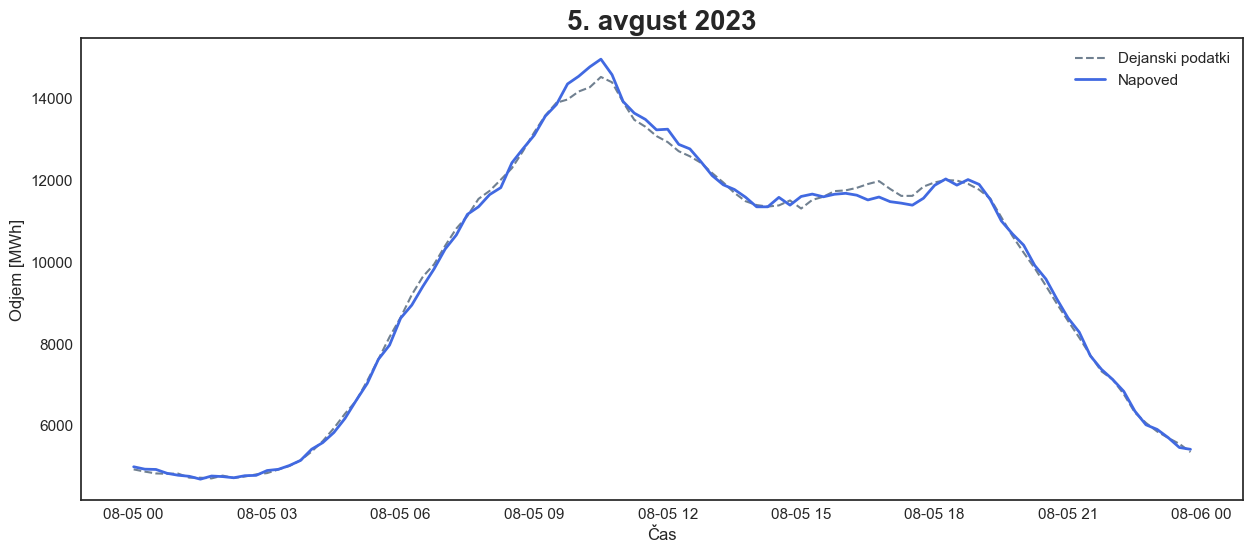

In [313]:
izrisi_graf_napovedi(podatki.loc[day, 'Odjem ACT'], forecast_AG_1, '5. avgust 2023')

In [282]:
train_data_diff_96_2 = ts_diff['2021-11-02':'2023-09-23'] 
train_exog_2 = podatki.loc['2021-11-02':'2023-09-23', ['Temperatura FC', 'Sevanje FC']]
day_2 = '2023-09-24'
next_day_2 = '2023-09-25'
test_data_diff_96_2 = ts_diff[day_2] 
test_exog_2 = podatki.loc[day_2, ['Temperatura FC', 'Sevanje FC']]

forecast_AG_2 = SARIMA_GARCH_forecast(podatki, train_data_diff_96_2, train_exog_2, test_data_diff_96_2, test_exog_2, day_2, next_day_2)    

Iteration:      1,   Func. Count:      7,   Neg. LLF: 36026213800.34109
Iteration:      2,   Func. Count:     14,   Neg. LLF: -197590.1381217609
Optimization terminated successfully    (Exit mode 0)
            Current function value: -197590.13811429418
            Iterations: 6
            Function evaluations: 14
            Gradient evaluations: 2


In [297]:
rmse_mape_AG_2 = RMSE_MAPE(podatki.loc[day_2, 'Odjem ACT'], forecast_AG_2)
rmse_mape_AG_2

[365.3721596038436, 2.39189066507517]

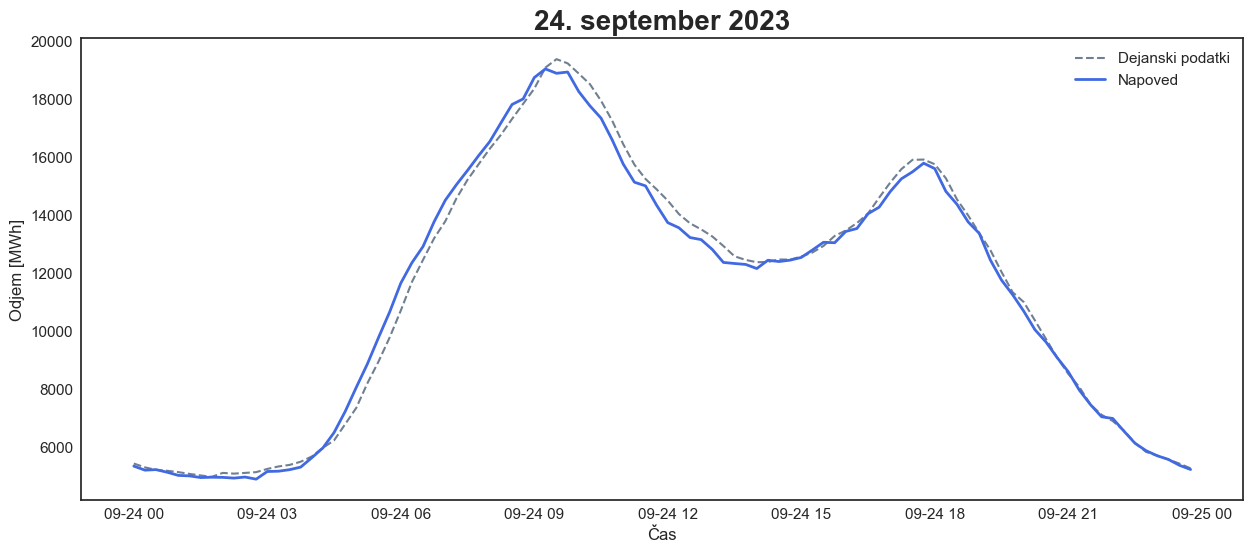

In [314]:
izrisi_graf_napovedi(podatki.loc[day_2, 'Odjem ACT'], forecast_AG_2, '24. september 2023')

In [284]:
train_data_diff_96_3 = ts_diff['2021-11-02':'2023-11-15'] 
train_exog_3 = podatki.loc['2021-11-02':'2023-11-15', ['Temperatura FC', 'Sevanje FC']]
day_3 = '2023-11-16'
next_day_3 = '2023-11-17'
test_data_diff_96_3 = ts_diff[day_3] 
test_exog_3 = podatki.loc[day_3, ['Temperatura FC', 'Sevanje FC']]

forecast_AG_3 = SARIMA_GARCH_forecast(podatki, train_data_diff_96_3, train_exog_3, test_data_diff_96_3, test_exog_3, day_3, next_day_3)    

Iteration:      1,   Func. Count:      6,   Neg. LLF: -212135.8314107587
Optimization terminated successfully    (Exit mode 0)
            Current function value: -212135.8314811698
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1


In [298]:
rmse_mape_AG_3 = RMSE_MAPE(podatki.loc[day_3, 'Odjem ACT'], forecast_AG_3)
rmse_mape_AG_3

[176.9005116185304, 1.1994864323442025]

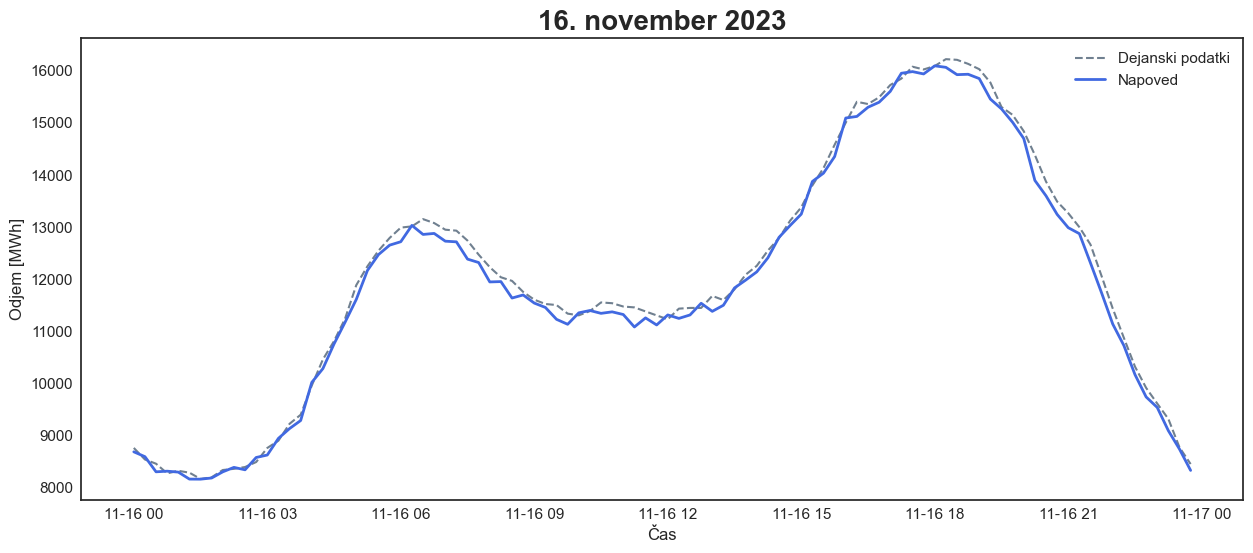

In [315]:
izrisi_graf_napovedi(podatki.loc[day_3, 'Odjem ACT'], forecast_AG_3, '16. november 2023')

In [288]:
train_data_diff_96_4 = ts_diff['2021-11-02':'2023-12-29'] 
train_exog_4 = podatki.loc['2021-11-02':'2023-12-29', ['Temperatura FC', 'Sevanje FC']]
day_4 = '2023-12-30'
next_day_4 = '2023-12-31'
test_data_diff_96_4 = ts_diff[day_4] 
test_exog_4 = podatki.loc[day_4, ['Temperatura FC', 'Sevanje FC']]

forecast_AG_4 = SARIMA_GARCH_forecast(podatki, train_data_diff_96_4, train_exog_4, test_data_diff_96_4, test_exog_4, day_4, next_day_4)    

Iteration:      1,   Func. Count:      7,   Neg. LLF: 41435677137.17293
Iteration:      2,   Func. Count:     14,   Neg. LLF: -225554.16216908031
Optimization terminated successfully    (Exit mode 0)
            Current function value: -225554.1621604968
            Iterations: 6
            Function evaluations: 14
            Gradient evaluations: 2


In [299]:
rmse_mape_AG_4 = RMSE_MAPE(podatki.loc[day_4, 'Odjem ACT'], forecast_AG_4)
rmse_mape_AG_4

[224.12348820320054, 1.0460542798916153]

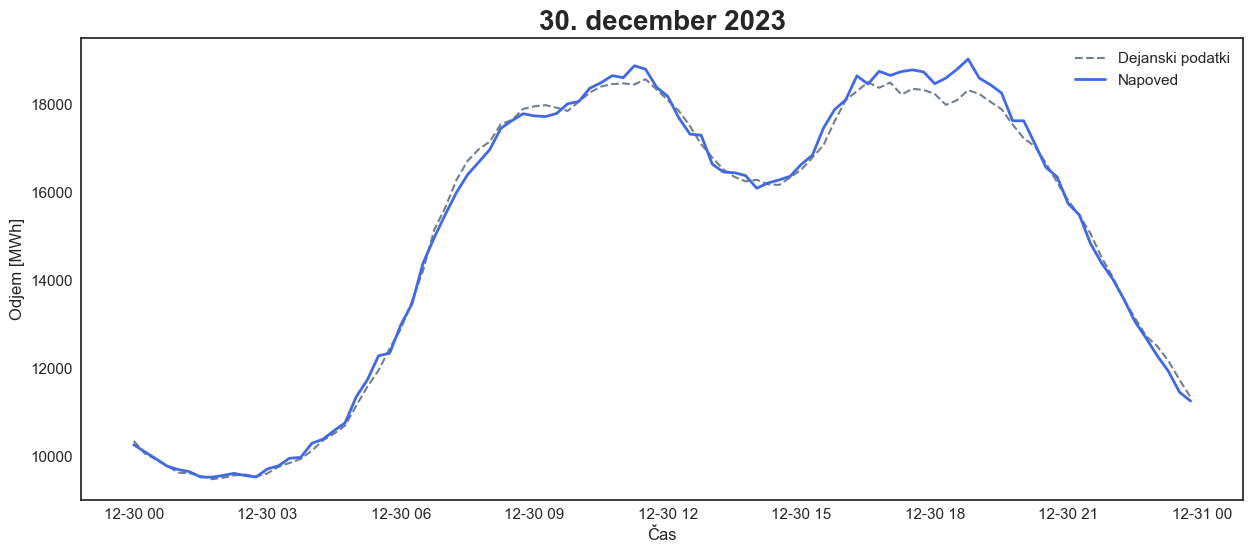

In [316]:
izrisi_graf_napovedi(podatki.loc[day_4, 'Odjem ACT'], forecast_AG_4, '30. december 2023')

In [290]:
train_data_diff_96_5 = ts_diff['2021-11-02':'2024-01-06'] 
train_exog_5 = podatki.loc['2021-11-02':'2024-01-06', ['Temperatura FC', 'Sevanje FC']]
day_5 = '2024-01-07'
next_day_5 = '2024-01-08'
test_data_diff_96_5 = ts_diff[day_5] 
test_exog_5 = podatki.loc[day_5, ['Temperatura FC', 'Sevanje FC']]

forecast_AG_5 = SARIMA_GARCH_forecast(podatki, train_data_diff_96_5, train_exog_5, test_data_diff_96_5, test_exog_5, day_5, next_day_5)    

Iteration:      1,   Func. Count:      7,   Neg. LLF: 41842903178.99651
Iteration:      2,   Func. Count:     15,   Neg. LLF: 259255.04154147193
Iteration:      3,   Func. Count:     25,   Neg. LLF: -163659.9372473341
Iteration:      4,   Func. Count:     35,   Neg. LLF: -227952.9368315563
Optimization terminated successfully    (Exit mode 0)
            Current function value: -227952.9368465954
            Iterations: 8
            Function evaluations: 35
            Gradient evaluations: 4


In [300]:
rmse_mape_AG_5 = RMSE_MAPE(podatki.loc[day_5, 'Odjem ACT'], forecast_AG_5)
rmse_mape_AG_5

[399.5783317069575, 1.8385271647174704]

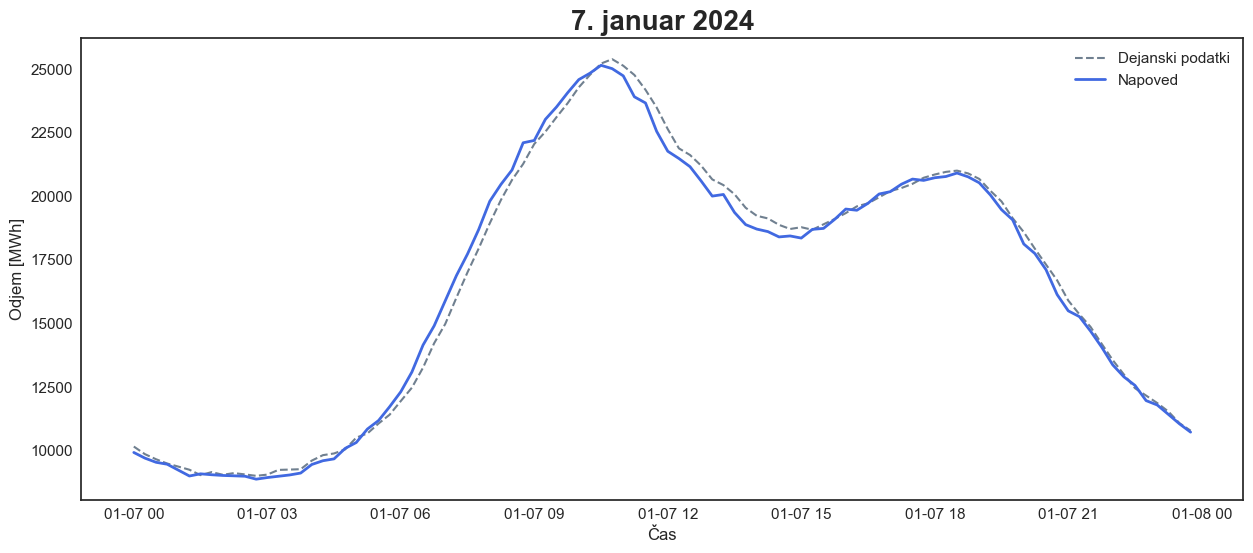

In [317]:
izrisi_graf_napovedi(podatki.loc[day_5, 'Odjem ACT'], forecast_AG_5, '7. januar 2024')

In [291]:
train_data_diff_96_6 = ts_diff['2021-11-02':'2024-02-11'] 
train_exog_6 = podatki.loc['2021-11-02':'2024-02-11', ['Temperatura FC', 'Sevanje FC']]
day_6 = '2024-02-12'
next_day_6 = '2024-02-13'
test_data_diff_96_6 = ts_diff[day_6] 
test_exog_6 = podatki.loc[day_6, ['Temperatura FC', 'Sevanje FC']]

forecast_AG_6 = SARIMA_GARCH_forecast(podatki, train_data_diff_96_6, train_exog_6, test_data_diff_96_6, test_exog_6, day_6, next_day_6)    

Iteration:      1,   Func. Count:      6,   Neg. LLF: -238272.4970987809
Optimization terminated successfully    (Exit mode 0)
            Current function value: -238272.49717485814
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1


In [301]:
rmse_mape_AG_6 = RMSE_MAPE(podatki.loc[day_6, 'Odjem ACT'], forecast_AG_6)
rmse_mape_AG_6

[248.98073841155608, 1.2872776348067727]

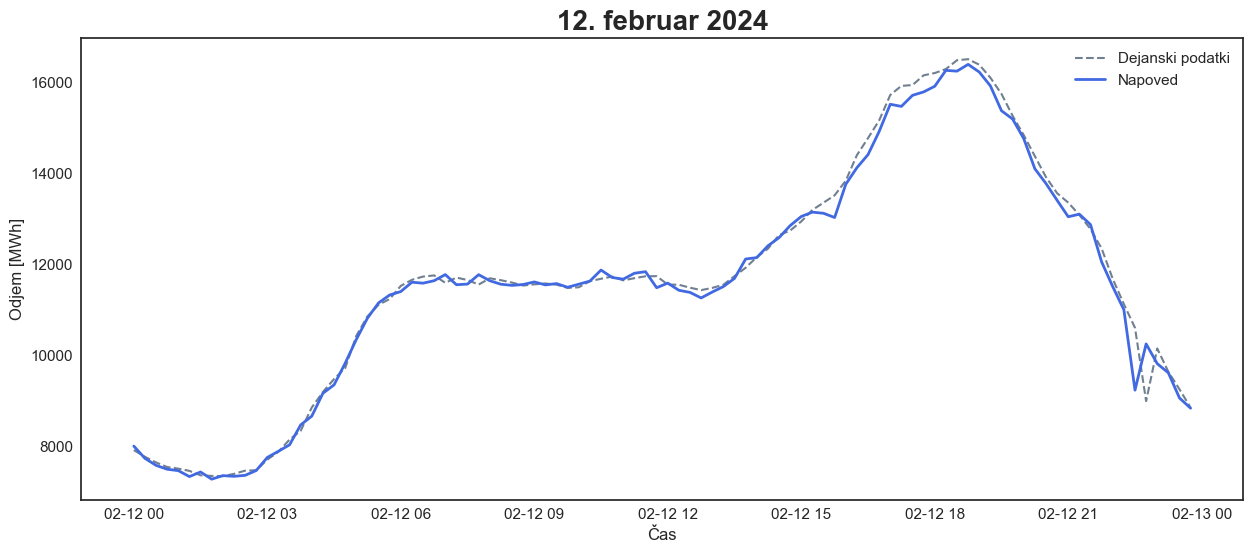

In [318]:
izrisi_graf_napovedi(podatki.loc[day_6, 'Odjem ACT'], forecast_AG_6, '12. februar 2024')

In [319]:
from statistics import mean

rmse_sez = [rmse_mape_AG_1[0], rmse_mape_AG_2[0], rmse_mape_AG_3[0], rmse_mape_AG_4[0], rmse_mape_AG_5[0], rmse_mape_AG_6[0]]
mape_sez = [rmse_mape_AG_1[1], rmse_mape_AG_2[1], rmse_mape_AG_3[1], rmse_mape_AG_4[1], rmse_mape_AG_5[1], rmse_mape_AG_6[1]]

pd.DataFrame([
    ['5. avgust 2023', rmse_mape_AG_1[0], rmse_mape_AG_1[1]], 
    ['24. september 2023', rmse_mape_AG_2[0], rmse_mape_AG_2[1]], 
    ['16. november 2023', rmse_mape_AG_3[0], rmse_mape_AG_3[1]], 
    ['30. december 2023', rmse_mape_AG_4[0], rmse_mape_AG_4[1]], 
    ['7. januar 2023', rmse_mape_AG_5[0], rmse_mape_AG_5[1]], 
    ['12. februar 2023', rmse_mape_AG_6[0], rmse_mape_AG_6[1]], 
    ['Povprečje', mean(rmse_sez), mean(mape_sez)]
],
columns=('Datum', 'RMSE', 'MAPE'))

,Datum,RMSE,MAPE
0,5. avgust 2023,156.600248,1.103661
1,24. september 2023,365.372160,2.391891
2,16. november 2023,176.900512,1.199486
3,30. december 2023,224.123488,1.046054
4,7. januar 2023,399.578332,1.838527
5,12. februar 2023,248.980738,1.287278
6,Povprečje,261.925913,1.477816
